In [1]:
import os
import tensorflow as tf
import random
import numpy as np
import cv2
import time
import math

In [2]:
NUM_CLASSES = 101           # The UCF-101 dataset has 101 classes
CROP_SIZE = 112             # Images are cropped to (CROP_SIZE, CROP_SIZE)
CHANNELS = 3                # RGB Channels
NUM_FRAMES_PER_CLIP = 16    # Number of frames per video clip

In [3]:
def conv3d(name, l_input, w, b):
    return tf.nn.bias_add(
        tf.nn.conv3d(l_input, w, strides=[1, 1, 1, 1, 1], padding='SAME', name=name), 
        b)

def max_pool(name, l_input, k):
    return tf.nn.max_pool3d(l_input, ksize=[1, k, 2, 2, 1], 
                            strides=[1, k, 2, 2, 1], padding='SAME', 
                            name=name)

def inference_c3d(_X, _dropout, batch_size, _weights, _biases):
    
    # Convolution Layer
    conv1 = conv3d('conv1', _X, _weights['wc1'], _biases['bc1'])
    conv1 = tf.nn.relu(conv1, name='relu1')
    pool1 = max_pool('pool1', conv1, k=1)
    
    # Convolution Layer
    conv2 = conv3d('conv2', pool1, _weights['wc2'], _biases['bc2'])
    conv2 = tf.nn.relu(conv2, name='relu2')
    pool2 = max_pool('pool2', conv2, k=2)
    
    # Convolution Layer
    conv3 = conv3d('conv3a', pool2, _weights['wc3a'], _biases['bc3a'])
    conv3 = tf.nn.relu(conv3, name='relu3a')
    conv3 = conv3d('conv3b', conv3, _weights['wc3b'], _biases['bc3b'])
    conv3 = tf.nn.relu(conv3, name='relu3b')
    pool3 = max_pool('pool3', conv3, k=2)
    
    # Convolution Layer
    conv4 = conv3d('conv4a', pool3, _weights['wc4a'], _biases['bc4a'])
    conv4 = tf.nn.relu(conv4, name='relu4a')
    conv4 = conv3d('conv4b', conv4, _weights['wc4b'], _biases['bc4b'])
    conv4 = tf.nn.relu(conv4, name='relu4b')
    pool4 = max_pool('pool4', conv4, k=2)
    
    # Convolution Layer
    conv5 = conv3d('conv5a', pool4, _weights['wc5a'], _biases['bc5a'])
    conv5 = tf.nn.relu(conv5, name='relu5a')
    conv5 = conv3d('conv5b', conv5, _weights['wc5b'], _biases['bc5b'])
    conv5 = tf.nn.relu(conv5, name='relu5b')
    pool5 = max_pool('pool5', conv5, k=2)
    
    # Fully connected layer
    pool5 = tf.transpose(pool5, perm=[0, 1, 4, 2, 3])
    dense1 = tf.reshape(pool5, [batch_size, _weights['wd1'].get_shape().as_list()[0]]) # Reshape conv3 output to fit dense layer input
    dense1 = tf.matmul(dense1, _weights['wd1']) + _biases['bd1']
    
    dense1 = tf.nn.relu(dense1, name='fc1') # Relu activation
    dense1 = tf.nn.dropout(dense1, _dropout)
    
    dense2 = tf.nn.relu(
        tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], 
        name='fc2') # Relu activation
    dense2 = tf.nn.dropout(dense2, _dropout)
    
    # Output: class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    
    return out

In [4]:
# Basic model parameters as external flags.
flags = tf.app.flags
gpu_num = 1 # Number of my pc's gpu is 1.
flags.DEFINE_string('f', '', 'kernel') # Only use on Jupyter Notebook.
flags.DEFINE_integer('max_steps', 5000, 'Number of steps to run trainer.')
flags.DEFINE_integer('batch_size', 10, 'Batch size.')
FLAGS = flags.FLAGS
MOVING_AVERAGE_DECAY = 0.9999
model_save_dir = './models'

# Videos to Images

In [5]:
import cv2

In [6]:
video_path = 'E:/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi'
vidcap = cv2.VideoCapture(video_path)

In [7]:
fps = vidcap.get(cv2.CAP_PROP_FPS)
print('Frmaes per second using '
      'video.get(cv2.CAP_PROP_FPS) : {}'.format(cv2.CAP_PROP_FPS))

Frmaes per second using video.get(cv2.CAP_PROP_FPS) : 5


In [8]:
fps

25.0

In [9]:
num_frames = 200

In [10]:
res = []
for i in range(num_frames):
    content = vidcap.read()
    res.append(content)

In [11]:
len(res)

200

In [12]:
len([frame for ret, frame in res if ret])

164

In [13]:
for parent, dirnames, filenames in os.walk('E:/UCF101/UCF-101'):
    print('{:<40s}\t{:>3d}\t{:>3d}'.format(
        parent, len(dirnames), len(filenames)))

E:/UCF101/UCF-101                       	101	  0
E:/UCF101/UCF-101\ApplyEyeMakeup        	  0	145
E:/UCF101/UCF-101\ApplyLipstick         	  0	114
E:/UCF101/UCF-101\Archery               	  0	145
E:/UCF101/UCF-101\BabyCrawling          	  0	132
E:/UCF101/UCF-101\BalanceBeam           	  0	108
E:/UCF101/UCF-101\BandMarching          	  0	155
E:/UCF101/UCF-101\BaseballPitch         	  0	150
E:/UCF101/UCF-101\Basketball            	  0	134
E:/UCF101/UCF-101\BasketballDunk        	  0	131
E:/UCF101/UCF-101\BenchPress            	  0	160
E:/UCF101/UCF-101\Biking                	  0	134
E:/UCF101/UCF-101\Billiards             	  0	150
E:/UCF101/UCF-101\BlowDryHair           	  0	131
E:/UCF101/UCF-101\BlowingCandles        	  0	109
E:/UCF101/UCF-101\BodyWeightSquats      	  0	112
E:/UCF101/UCF-101\Bowling               	  0	155
E:/UCF101/UCF-101\BoxingPunchingBag     	  0	163
E:/UCF101/UCF-101\BoxingSpeedBag        	  0	134
E:/UCF101/UCF-101\BreastStroke          	  0	101
E:/UCF101/UCF-101\Br

In [14]:
from PIL import Image

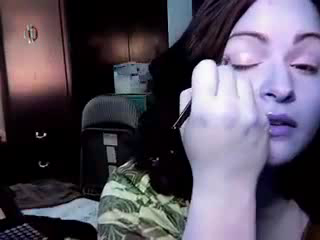

In [15]:
Image.fromarray(res[0][1])

In [16]:
from tqdm import tqdm

In [ ]:
filepath = 'E:/UCF101/UCF-101'
avi_generater = [contents for contents in os.walk(filepath)]
for parent, dirnames, filenames in tqdm(avi_generater):
    if len(filenames) == 0: continue
    for filename in filenames:
        if filename.split('.')[1] != 'avi': continue
        orig_filename = filename.split('.avi')[0]
        img_path = os.path.join(parent, orig_filename)
        if not os.path.exists(img_path):
            os.makedirs(img_path)
        vidcap = cv2.VideoCapture(os.path.join(parent, filename))
        num = 1
        while True:
            ret, frame = vidcap.read()
            if not ret: break
            im = Image.fromarray(frame)
            im.save(
                os.path.join(
                    img_path, orig_filename+'{:05d}.jpg'.format(num)))
            num += 1

 12%|█████████▎                                                                     | 12/102 [07:48<1:04:16, 42.85s/it]

In [6]:
# run_training

# Get the sets of images and labels for training, validation, and
# Tell TensorFlow that the model will be built into the default Graph.

# Create model directory
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
    print('Make Dir.: ' + model_save_dir)
else:
    print('Dir. is already exist. : ' + model_save_dir)

Make Dir.: ./models


In [ ]:
use_pretrain